In [22]:
import pandas as pd
import os 

os.chdir('/Users/katherineridley/Projects/PlaqueStack/OC_6E10/')
# Step 1: Load the astrocyte_data.csv file and remove small astrocytes
astrocyte_df = pd.read_csv('astrocyte_data.csv')

# Remove astrocytes with a volume less than 200 μm³
astrocyte_df = astrocyte_df[astrocyte_df['volume'] >= 200]
astrocyte_df = astrocyte_df[astrocyte_df['surface_area'] <= 8000]

#save the cleaned data to a new csv file
astrocyte_df.to_csv('cleaned_astrocyte_data.csv', index=False)

print(astrocyte_df)

# Step 2: Load the metadata.csv file
metadata_df = pd.read_csv('metadata.csv')

# Step 3: Map 'Genotype' to astrocyte_df by matching the first three characters of 'image_file' with 'filename'

# Create a new column in astrocyte_df with the first three characters of 'image_file'
astrocyte_df['filename'] = astrocyte_df['image_file'].astype(str).str[:3]

# Ensure 'filename' columns are strings in both dataframes
astrocyte_df['filename'] = astrocyte_df['filename'].astype(str)
metadata_df['filename'] = metadata_df['filename'].astype(str)

# Merge the dataframes on 'filename'
astrocyte_df = astrocyte_df.merge(
    metadata_df[['filename', 'Genotype']],
    on='filename',
    how='left'
)

#save the merged data to a new csv file
astrocyte_df.to_csv('astrocyte_data_with_genotype.csv', index=False)

# Step 4: Generate means of astrocyte responses per image_file and add requested columns

# Specify the columns that represent astrocyte responses
response_columns = ['volume', 'mean_intensity', 'complexity', 'surface_area', 'num_branches', 'num_endpoints', 'num_branches', 'total_branch_length']

# Ensure that the response columns exist in the dataframe
missing_columns = [col for col in response_columns if col not in astrocyte_df.columns]
if missing_columns:
    print(f"Error: The following response columns are missing in astrocyte_data.csv: {missing_columns}")
else:
    # Group by 'image_file' and 'Genotype'
    grouped = astrocyte_df.groupby(['image_file', 'Genotype'])

    # Calculate mean of response columns
    mean_responses = grouped[response_columns].mean().reset_index()

    # Count the number of astrocytes per group
    number_of_astrocytes = grouped.size().reset_index(name='number_of_astrocytes')

    # Calculate the number of astrocytes touching plaque
    if 'touching_plaque' in astrocyte_df.columns:
        # Ensure 'touching_plaque' is boolean
        astrocyte_df['touching_plaque'] = astrocyte_df['touching_plaque'].astype(str).str.upper()
        astrocyte_df['touching_plaque'] = astrocyte_df['touching_plaque'].map({'TRUE': True, 'FALSE': False})
        
        # Handle any NaN values that may have resulted from mapping
        astrocyte_df['touching_plaque'] = astrocyte_df['touching_plaque'].fillna(False)

        number_touching_plaque = grouped['touching_plaque'].sum().reset_index(name='number_touching_plaque')
    else:
        print("Error: 'touching_plaque' column is missing in astrocyte_data.csv.")
        # Create an empty DataFrame with the necessary columns
        number_touching_plaque = pd.DataFrame(columns=['image_file', 'Genotype', 'number_touching_plaque'])

    # Merge the counts into mean_responses
    mean_responses = mean_responses.merge(number_of_astrocytes, on=['image_file', 'Genotype'])
    mean_responses = mean_responses.merge(number_touching_plaque, on=['image_file', 'Genotype'], how='left')

    # Display the result
    print(mean_responses)

    # Optionally, save the result to a CSV file
    mean_responses.to_csv('mean_astrocyte_responses_per_image.csv', index=False)


      label     volume  centroid_z  centroid_y  centroid_x  mean_intensity  \
0         1   324.9720    7.467996    4.996696   83.426859    16164.710568   
1         2   691.0596    7.680294   11.645272  174.032674    16275.018332   
2         3   641.2608    6.457862    9.318092   24.952000    16065.862470   
3         4   962.0208    8.210696   14.145459  128.382430    16118.432878   
6         7  1131.0516    9.200779   37.753795   43.752174    16187.759632   
...     ...        ...         ...         ...         ...             ...   
6413     11  2456.5356   15.226381   98.376499   70.062584     7667.483863   
6420     18   665.0100   10.310402  124.497612   78.064698     7813.431815   
6451     49   319.3992   20.291641   56.040694   13.738959     7866.717387   
6514      9   351.8964    6.446184  169.229798  132.684263     2183.560998   
6551      9   931.0464   11.914741   95.211569  105.527506     3290.100606   

      num_endpoints  num_branch_points  num_branches  total_bra

In [19]:
mean_responses = pd.read_csv('mean_astrocyte_responses_per_image.csv')

#cut off number_of_astrocytes at >2
mean_responses = mean_responses[mean_responses['number_of_astrocytes'] > 2]

#print(mean_responses)

# Step 5: Generate a summary table of the mean responses per Genotype

# Group by 'Genotype'

grouped_genotype = mean_responses.groupby('Genotype')

# Calculate the mean of response columns
mean_responses_genotype = grouped_genotype[response_columns].mean().reset_index()

#rint(mean_responses_genotype)

# mean for number_of_astrocytes and number_touching_plaque
mean_number_of_astrocytes = grouped_genotype['number_of_astrocytes'].mean().reset_index()

mean_number_touching_plaque = grouped_genotype['number_touching_plaque'].mean().reset_index()

# Merge the counts into mean_responses_genotype
mean_responses_genotype = mean_responses_genotype.merge(mean_number_of_astrocytes, on='Genotype')

mean_responses_genotype = mean_responses_genotype.merge(mean_number_touching_plaque, on='Genotype')

# Display the result
print(mean_responses_genotype)


   Genotype      volume  mean_intensity  complexity  surface_area  \
0  APP-FIRE  698.596706     8768.537044    0.299996   2374.104830   
1    APP-WT  874.365950    12305.962433    0.301771   2886.740153   

   num_branches  num_endpoints  num_branches  total_branch_length  \
0     66.004986      27.564689     66.004986           324.106431   
1     93.519772      36.715991     93.519772           433.356335   

   number_of_astrocytes  number_touching_plaque  
0                 16.08                     1.4  
1                 19.00                     1.4  


In [20]:
#ttest_ind
from scipy.stats import ttest_ind

# Separate the data into two groups based on Genotype
group1 = mean_responses[mean_responses['Genotype'] == 'APP-WT']
group2 = mean_responses[mean_responses['Genotype'] == 'APP-FIRE']

# Perform t-test for each response column
for col in response_columns:
    t_stat, p_val = ttest_ind(group1[col], group2[col])
    print(f"T-test for {col}: t-statistic = {t_stat}, p-value = {p_val}")

    # t test for number_of_astrocytes and number_touching_plaque
t_stat, p_val = ttest_ind(group1['number_of_astrocytes'], group2['number_of_astrocytes'])
print(f"T-test for number_of_astrocytes: t-statistic = {t_stat}, p-value = {p_val}")

t_stat, p_val = ttest_ind(group1['number_touching_plaque'], group2['number_touching_plaque'])
print(f"T-test for number_touching_plaque: t-statistic = {t_stat}, p-value = {p_val}")


T-test for volume: t-statistic = 1.4798546389344513, p-value = 0.14715557418900413
T-test for mean_intensity: t-statistic = 2.1238492297677216, p-value = 0.04025057136143814
T-test for complexity: t-statistic = 0.043547103832067176, p-value = 0.9654934442097207
T-test for surface_area: t-statistic = 2.5636104598152296, p-value = 0.014438986051721656
T-test for num_branches: t-statistic = 2.665667346744469, p-value = 0.011219559438502797
T-test for num_endpoints: t-statistic = 2.5466173844482367, p-value = 0.015050907369580159
T-test for num_branches: t-statistic = 2.665667346744469, p-value = 0.011219559438502797
T-test for total_branch_length: t-statistic = 2.808141248313436, p-value = 0.007823884997273687
T-test for number_of_astrocytes: t-statistic = 0.7009731898118601, p-value = 0.48759026052810295
T-test for number_touching_plaque: t-statistic = 0.0, p-value = 1.0


Index(['label', 'volume', 'centroid_z', 'centroid_y', 'centroid_x',
       'mean_intensity', 'num_endpoints', 'num_branch_points', 'num_branches',
       'total_branch_length', 'surface_area', 'complexity',
       'mean_distance_to_plaque', 'touching_plaque', 'image_file', 'filename',
       'Genotype'],
      dtype='object')
   Genotype      volume  mean_intensity  complexity  surface_area  \
0  APP-FIRE  843.596566    11010.085870    0.355927   2445.262124   
1    APP-WT  929.742000    15627.354525    0.339598   2738.072647   

   num_branches  num_endpoints  num_branches  total_branch_length  
0     78.273399      32.078818     78.273399           370.013053  
1     98.010101      38.282828     98.010101           434.971740  
   Genotype  mean_distance_to_plaque
0  APP-FIRE               270.523705
1    APP-WT               234.539936
T-test for volume: t-statistic = 1.2393383183202227, p-value = 0.21563499549756615


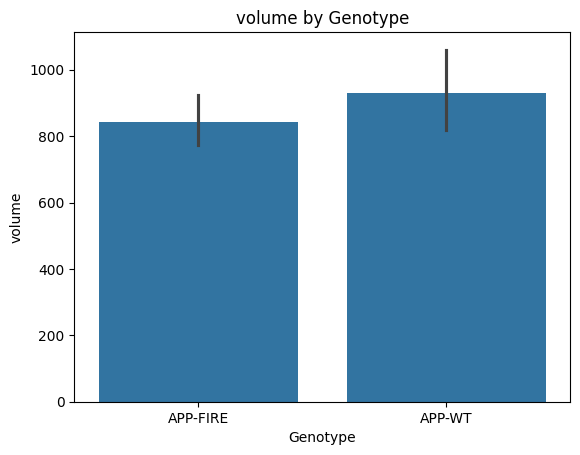

T-test for mean_intensity: t-statistic = 11.333100597160499, p-value = 1.865712464027716e-27


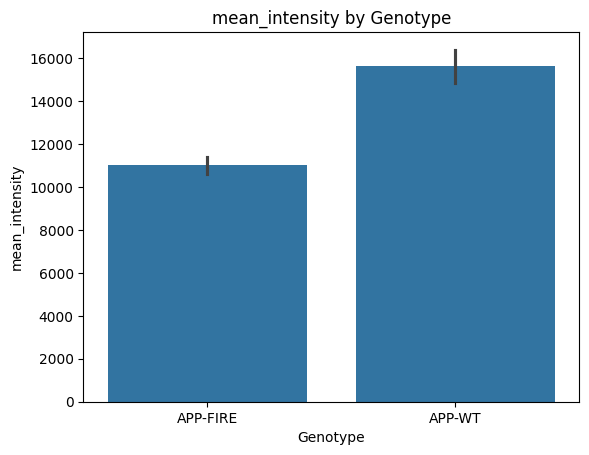

T-test for complexity: t-statistic = -0.967545416832276, p-value = 0.3336051350180844


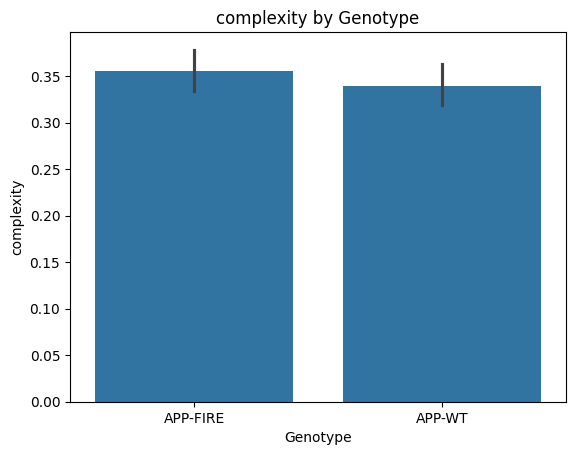

T-test for surface_area: t-statistic = 2.5221093039573703, p-value = 0.01188572354887456


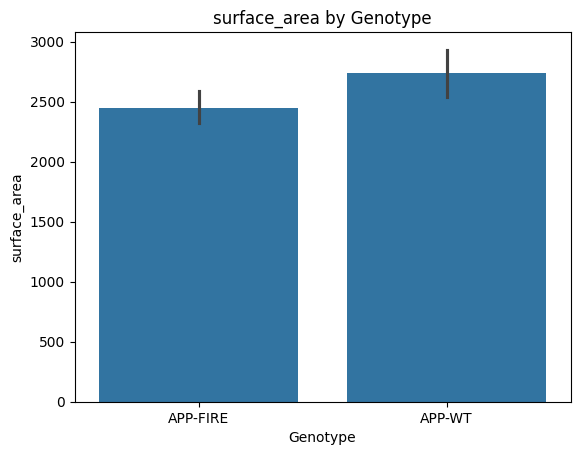

T-test for num_branches: t-statistic = 3.048743995846118, p-value = 0.002384485181371976


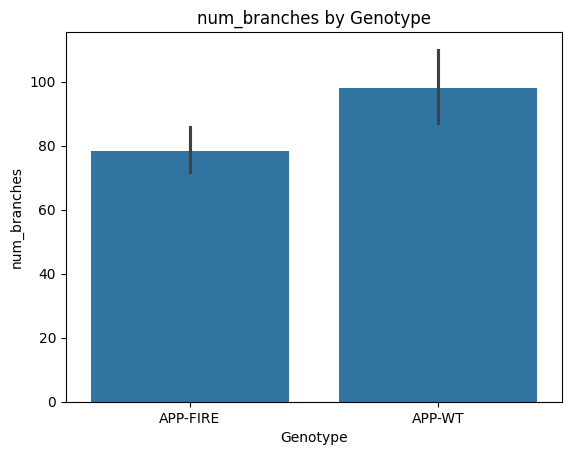

T-test for num_endpoints: t-statistic = 2.778854650986772, p-value = 0.005601156969308966


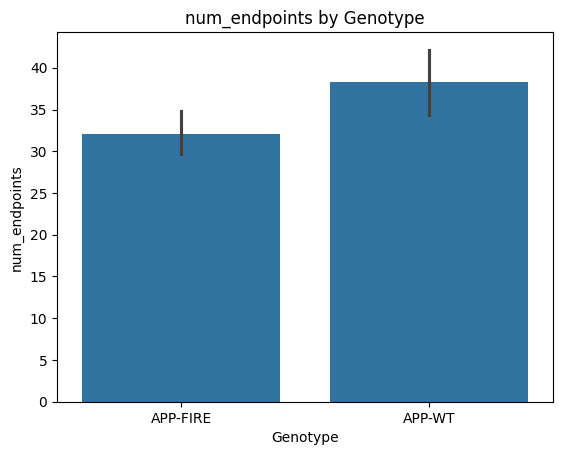

T-test for num_branches: t-statistic = 3.048743995846118, p-value = 0.002384485181371976


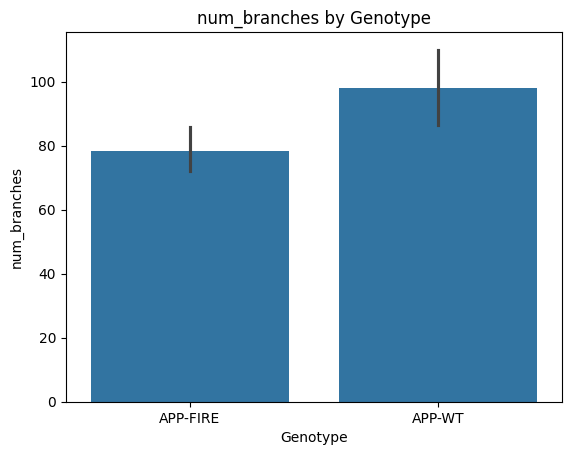

T-test for total_branch_length: t-statistic = 2.659245024767508, p-value = 0.008010430016691954


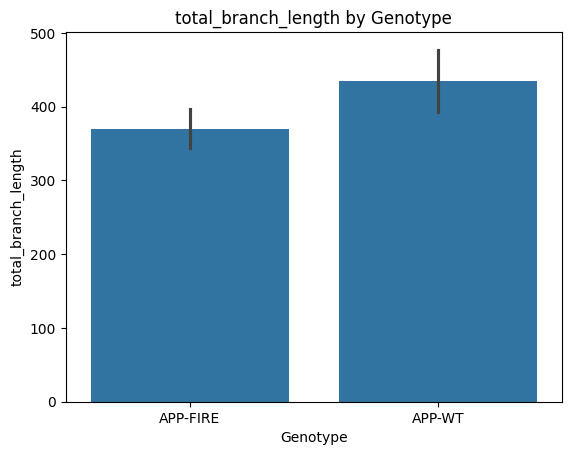

T-test for mean_distance_to_plaque: t-statistic = -3.284771066812603, p-value = 0.001071412509294406


In [21]:
print(astrocyte_df.columns)

# Step 6: Generate a summary table of the mean responses per Genotype

# Group by 'Genotype' and 'touching_plaque'
grouped_genotype_plaque = astrocyte_df.groupby(['Genotype'])

# Calculate the mean of response columns
mean_responses_genotype_plaque = grouped_genotype_plaque[response_columns].mean().reset_index()

#mean_distance_to_plaque
mean_distance_to_plaque = grouped_genotype_plaque['mean_distance_to_plaque'].mean().reset_index()

print(mean_responses_genotype_plaque)
print(mean_distance_to_plaque)




#ttest_ind
from scipy.stats import ttest_ind

# Separate the data into two groups based on Genotype
group1 = astrocyte_df[astrocyte_df['Genotype'] == 'APP-WT']
group2 = astrocyte_df[astrocyte_df['Genotype'] == 'APP-FIRE']

# Perform t-test for each response column
for col in response_columns:
    t_stat, p_val = ttest_ind(group1[col], group2[col])
    print(f"T-test for {col}: t-statistic = {t_stat}, p-value = {p_val}")

    #bar plot for each col in response_columns
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.barplot(x='Genotype', y=col, data=astrocyte_df)
    plt.title(f'{col} by Genotype')
    plt.show()

    # t test for 'mean_distance_to_plaque'
t_stat, p_val = ttest_ind(group1['mean_distance_to_plaque'], group2['mean_distance_to_plaque'])
print(f"T-test for mean_distance_to_plaque: t-statistic = {t_stat}, p-value = {p_val}")

    



In [16]:
import pandas as pd

# Load the data
file_path = 'cleaned_astrocyte_data.csv'
df = pd.read_csv(file_path)

# Extract the image identifier (first 3 characters of 'image_file')
df['image_id'] = df['image_file'].str[:3]

# List of features to extract
features = ['volume', 'mean_intensity', 'num_endpoints', 'num_branch_points', 'num_branches', 
            'total_branch_length', 'surface_area', 'complexity', 'mean_distance_to_plaque', 'touching_plaque']

# Create a CSV for each feature
for feature in features:
    # Create a new DataFrame with the image identifiers as columns
    feature_data = {}

    # For each unique image identifier, extract the feature data and reset the index
    for image_id in df['image_id'].unique():
        feature_data[image_id] = df[df['image_id'] == image_id][feature].reset_index(drop=True)

    # Combine the individual feature data for each image identifier into a new DataFrame
    feature_df = pd.DataFrame(feature_data)

    # Save the feature DataFrame to a new CSV file, filling from the top
    feature_df.to_csv(f'{feature}_per_image.csv', index=False)

print("Feature CSVs created successfully.")



Feature CSVs created successfully.


In [17]:
import pandas as pd

# Load the data
file_path = 'cleaned_astrocyte_data.csv'
df = pd.read_csv(file_path)

# Extract the image identifier (first 3 characters of 'image_file')
df['image_id'] = df['image_file'].str[:3]

# List of features to extract
features = ['volume', 'mean_intensity', 'num_endpoints', 'num_branch_points', 'num_branches', 
            'total_branch_length', 'surface_area', 'complexity', 'mean_distance_to_plaque', 'touching_plaque']

# Create a CSV for each feature with means per image_id
for feature in features:
    # Group by image_id and calculate the mean of each feature
    feature_mean_df = df.groupby('image_id')[feature].mean().reset_index()

    # Pivot the data so the image_id becomes the column names
    feature_mean_pivot = feature_mean_df.pivot(columns='image_id', values=feature)
    
    # Save the mean feature DataFrame to a new CSV file
    feature_mean_pivot.to_csv(f'{feature}_mean_per_image.csv', index=False)

print("Feature mean CSVs created successfully.")


Feature mean CSVs created successfully.


In [25]:
#descriptive stats by genotype

import pandas as pd

# Load the data
file_path = 'astrocyte_data_with_genotype.csv'
df = pd.read_csv(file_path)

print(df)

# describe the data by genotype
df.groupby('Genotype').describe().to_csv('descriptive_stats_by_genotype.csv')


     label     volume  centroid_z  centroid_y  centroid_x  mean_intensity  \
0        2   645.2460    6.277429    8.719231   44.722213     15230.61481   
1        3  3373.2612    8.084860   25.241314  137.554317     14966.33677   
2        4  1249.5060   10.391806   13.576401   74.858884     14898.95340   
3        5  2197.3356    7.907754   25.036928  171.381626     14835.76560   
4        7   964.1592   10.053162   27.135263  100.240075     15310.60559   
..     ...        ...         ...         ...         ...             ...   
698      9   268.4988    5.152407  106.253846  138.579517     11801.65295   
699     11   567.5832    8.280454  144.798779   13.059535     13405.44229   
700     12   200.8800    7.827903  149.308955  119.517561     12309.79839   
701     19   283.5648    7.284735  136.159470   28.545672     13386.08889   
702     22   317.4876   13.166343  178.491538   33.433214     13461.62364   

     num_endpoints  num_branch_points  num_branches  total_branch_length  \